In [1]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
test_dir = os.path.join('drive', 'MyDrive', 'data', 'test')
BATCH_SIZE=64
IMAGE_SIZE=(128, 128)
classes = os.listdir(test_dir)
n_classes = len(classes)

classes

['chair', 'clock', 'telephone']

In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)

Found 672 files belonging to 3 classes.


In [5]:
MODEL_PATH = os.path.join('drive', 'MyDrive', 'model')
model = tf.keras.models.load_model(MODEL_PATH)

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 6,403
Non-trainab

In [7]:
labels = np.array([])
images = np.array([]).reshape(-1, *IMAGE_SIZE, 3)
for img_batch, lbls in test_ds:
  images = np.concatenate([images, img_batch], axis=0)
  labels = np.append(labels, np.argmax(lbls, axis=-1))

images.shape, labels.shape

((672, 128, 128, 3), (672,))

In [8]:
preds = np.argmax(model.predict(images), axis=-1)

In [9]:
conf_mat = confusion_matrix(labels, preds)
accuracy = accuracy_score(labels, preds)

In [10]:
def get_precision_recall(conf_mat, class_num):
  precision = conf_mat[class_num, class_num] / conf_mat.sum(axis=0)[class_num]
  recall = conf_mat[class_num, class_num] / conf_mat.sum(axis=1)[class_num]
  return precision, recall

In [11]:
print('Accuracy is: {:.2f}'.format(accuracy * 100), end='\n\n')

print('Confusion matrix:')
print(conf_mat, end='\n\n')

for class_ in range(n_classes):
  precision, recall = get_precision_recall(conf_mat, class_)
  print("Class {} ({}):".format(class_, classes[class_]))
  print('\tPrecision: {:.2f}'.format(precision))
  print('\tRecall: {:.2f}'.format(recall), end='\n\n')

Accuracy is: 98.36

Confusion matrix:
[[223   0   1]
 [  2 219   3]
 [  5   0 219]]

Class 0 (chair):
	Precision: 0.97
	Recall: 1.00

Class 1 (clock):
	Precision: 1.00
	Recall: 0.98

Class 2 (telephone):
	Precision: 0.98
	Recall: 0.98



## Error analysis

In [154]:
# class 0 is chair
#       1 is clock
#       2 is telephone

def a_predicted_as_b(images, labels, preds, class_a, class_b, n_row, n_col):
  images = images[(labels == class_a) & (preds == class_b)]
  images = merge_images(images, n_row, n_col)
  return images

In [160]:
def merge_images(images, row, col):
  image = np.zeros([row*128, col*128, 3])
  counter = 0
  for i in range(1, row+1):
    for j in range(1, col+1):
      try:
        image[(i-1)*128:128 *i, (j-1)*128:128*j, :] = images[counter] / 255.0
        counter+=1
      except Exception as ex:
        return image
      
  return image

In [176]:
def preds_figure():
  plt.figure(figsize=(12, 12))
  for i in range(n_classes):
    for j in range(n_classes):
      plt.subplot(n_classes, n_classes, i * n_classes + j + 1)
      plt.title(f'{classes[i]} predicted as {classes[j]}')
      img = a_predicted_as_b(images, labels, preds, i, j, 3, 3)
      plt.imshow(img)
      plt.axis('off')

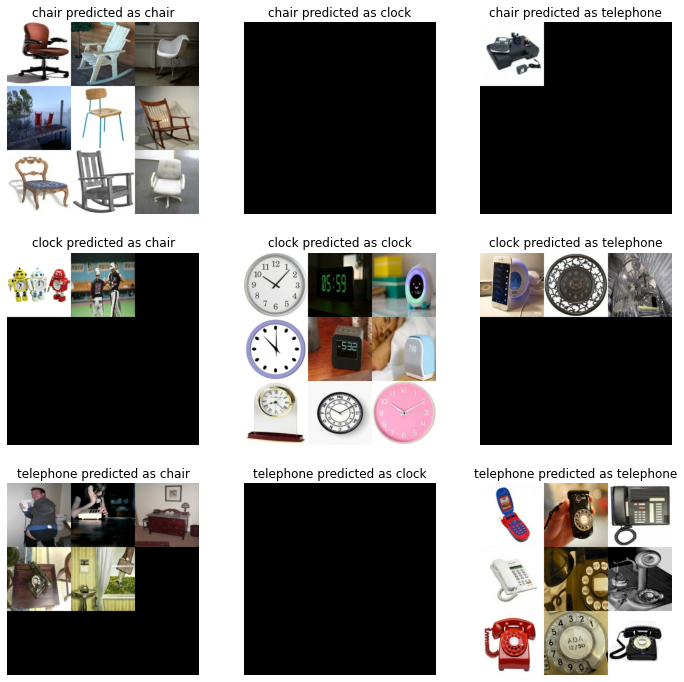

In [177]:
preds_figure()